In [1]:
from scipy.spatial import Voronoi
from skimage.draw import polygon
import matplotlib.pyplot as plt
from noise import snoise3
from PIL import Image
import numpy as np

In [2]:
n        = 256
size     = 1024
map_seed = 762345 

np.random.seed(map_seed)

In [3]:
def voronoi(points, size):
    
    edge_points = size * np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])
    new_points  = np.vstack([points, edge_points])
    vor         = Voronoi(new_points)
    
    return vor


def voronoi_map(vor, size):
    
    vor_map = np.zeros((size, size), dtype = np.uint32)
    
    for idx, region in enumerate(vor.regions):
        
        condition = [len(region) == 0, -1 in region]
        if any(condition): continue
        
        x, y   = np.array([vor.vertices[i][::-1] for i in region]).T
        rr, cc = polygon(x, y)
        
        in_box = np.where((0 <= rr) & (rr < size) & (0 <= cc) & (cc < size))
        rr, cc = rr[in_box], cc[in_box]
        
        vor_map[rr, cc] = idx
        
    return vor_map


def relax(points, size, k = 10):
    
    new_points = points.copy()
    for _ in range(k):
        
        vor        = voronoi(new_points, size)
        new_points = []
        for idx, region in enumerate(vor.regions):
            
            condition = [len(region) == 0, -1 in region]
            if any(condition): continue
            
            poly   = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis = 0)
            new_points.append(center)
            
        new_points = np.array(new_points).clip(0, size)
        
    return new_points


def noise_map(size, res, seed, octaves = 1, persistence = 0.5, lacunarity = 2.0):
    
    scale = size / res
    return np.array([[
                snoise3(
                 (x + 0.1) / scale,
                 y / scale, seed + map_seed,
                 octaves = octaves, persistence = persistence,
                 lacunarity = lacunarity
            )
            for x in range(size)]
            for y in range(size)
        ])

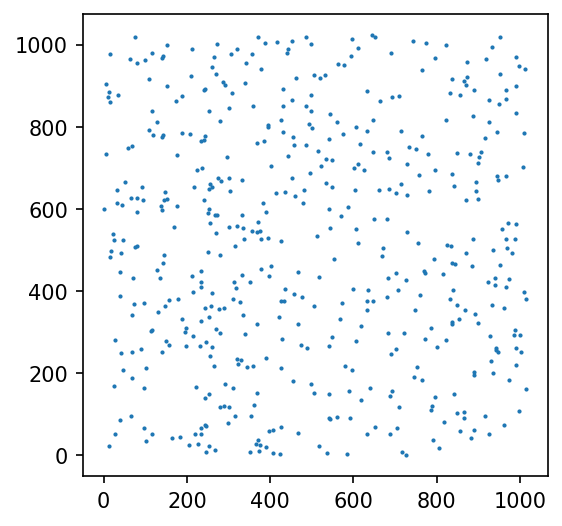

In [4]:
points  = np.random.randint(0, size, (514, 2))
vor     = voronoi(points, size)
vor_map = voronoi_map(vor, size)

fig = plt.figure(dpi = 150, figsize = (4, 4))
plt.scatter(*points.T, s = 1)

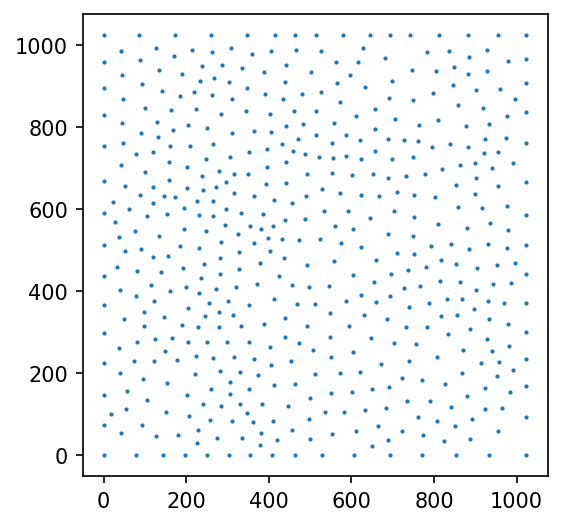

In [5]:
points  = relax(points, size, k = 100)
vor     = voronoi(points, size)
vor_map = voronoi_map(vor, size)

fig = plt.figure(dpi = 150, figsize = (4, 4))
plt.scatter(*points.T, s = 1)

In [6]:
boundary_displacement = 0
boundary_noise        = np.dstack([noise_map(size, 32, 200, octaves = 8), noise_map(size, 32, 250, octaves = 8)])
boundary_noise        = np.indices((size, size)).T + boundary_displacement * boundary_noise
boundary_noise        = boundary_noise.clip(0, size - 1).astype(np.uint32)
blurred_vor_map       = np.zeros_like(vor_map)

for x in range(size):
    for y in range(size):
        j, i = boundary_noise[x, y]
        blurred_vor_map[x, y] = vor_map[i, j]

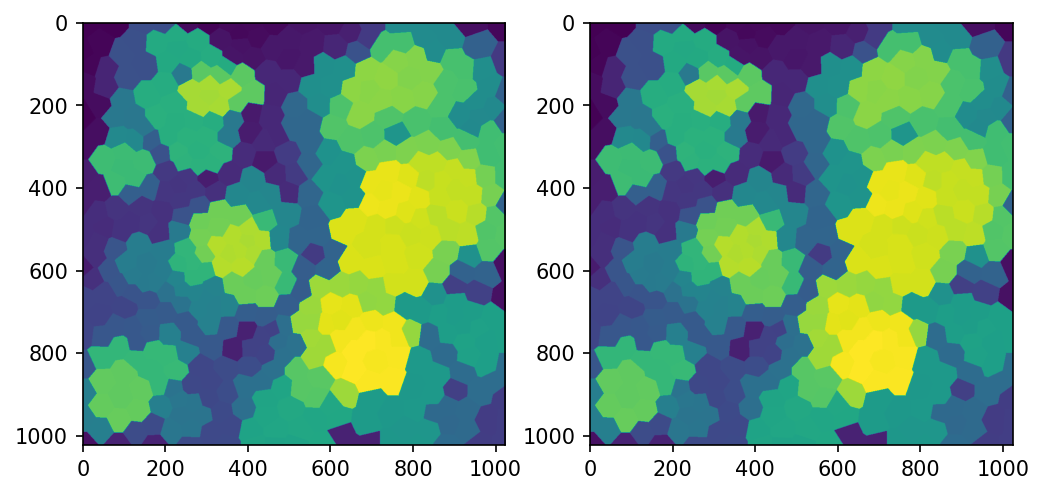

In [7]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)
axes[0].imshow(vor_map)
axes[1].imshow(blurred_vor_map)

Text(0.5, 1.0, 'Precipitation Map')

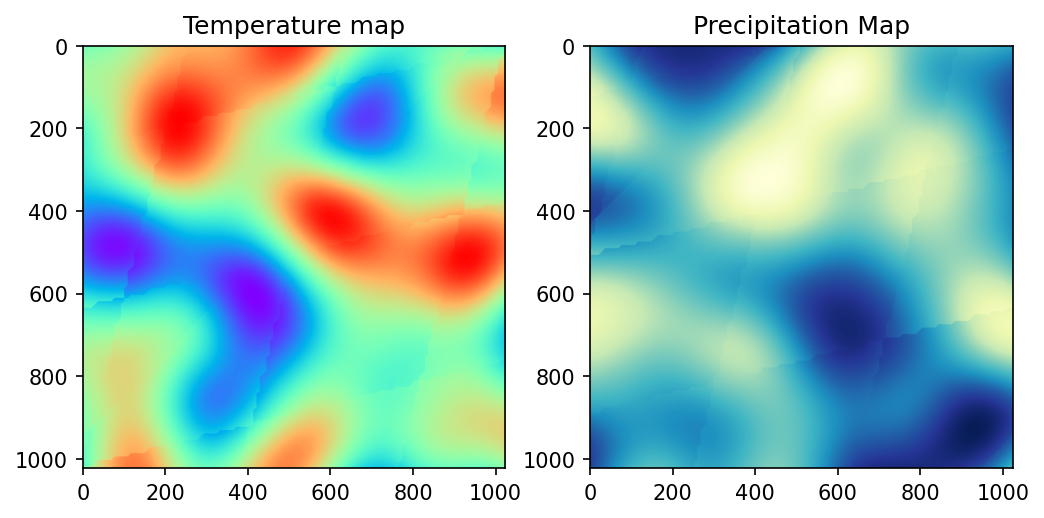

In [9]:
vor_map           = blurred_vor_map
temperature_map   = noise_map(size, 2, 10)
precipitation_map = noise_map(size, 2, 20)

fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].imshow(temperature_map, cmap = 'rainbow')
axes[0].set_title('Temperature map')

axes[1].imshow(precipitation_map, cmap = 'YlGnBu')
axes[1].set_title('Precipitation Map')